## Introduction

In this project we will be using a deep learning model to help classify satellite images of the amazon rain forest. **Here the main objective is not actually to get the best results for this task, rather to use this dataset to illustrate the use of the Fastai deep learning library** - in particular to demonstrate the uses of the high-level api as well as the mid-level api and show how this can be used to configure different types of datasets for different types of problems.

## Using Fastai to prepare data for the Amazon Image classification task

The amazon dataset comes from the [Understanding the Amazon from Space](https://www.kaggle.com/competitions/planet-understanding-the-amazon-from-space) project, which aims:

>'...to label satellite image chips with atmospheric conditions and various classes of land cover/land use. Resulting algorithms will help the global community better understand where, how, and why deforestation happens all over the world - and ultimately how to respond.'

Key aspects of this task include.

- Our data consists of images as well as multiple labels for each image
- Our task is *Multi-label Classification* i.e. to be able to predict one or more labels for a given image

While the main dataset has over 40,000 images - we will be using a small subset of this of just 200 images.

In an earlier project I looked at a different dataset of satellite images, in this case for an [image segmentation task rather than classification](2021-05-15-satellite-recognition-buildings-woodland-water-ai.html).

## Loading and examining the data

Let's see how we can use the Fastai library to prepare our data to perform this task, and start by loading the data.

In [1]:
#| include: false
!pip install -Uqq timm fastai fastkaggle
import timm
from fastkaggle import *
from fastai.vision.all import *
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")

In [2]:
path = untar_data(URLs.PLANET_TINY)
path.ls()

(#3) [Path('/root/.fastai/data/planet_tiny/labels.csv'),Path('/root/.fastai/data/planet_tiny/models'),Path('/root/.fastai/data/planet_tiny/train')]

So we have a folder called 'train' which we assume has the images, lets take a look to check.

In [3]:
(path/"train").ls()[:5]

(#5) [Path('/root/.fastai/data/planet_tiny/train/train_39223.jpg'),Path('/root/.fastai/data/planet_tiny/train/train_5302.jpg'),Path('/root/.fastai/data/planet_tiny/train/train_34793.jpg'),Path('/root/.fastai/data/planet_tiny/train/train_28156.jpg'),Path('/root/.fastai/data/planet_tiny/train/train_15839.jpg')]

We also have a labels.csv file, which would normally have the image names and their associated labels, lets verify this.

In [4]:
df = pd.read_csv(path/"labels.csv")
df.head()

,image_name,tags
0,train_31112,clear primary
1,train_4300,partly_cloudy primary water
2,train_39539,clear primary water
3,train_12498,agriculture clear primary road
4,train_9320,clear primary


Let's check how many images we have.

In [5]:
df.shape

(200, 2)

So this is a *multi-label classification* task, each image has one or more labels which we hope to predict. Lets get an idea of how many example images we have for each label.

In [6]:
new_df = df['tags'].str.split(expand=True).stack().value_counts().reset_index()
new_df.columns = ['Word', 'Frequency'] 
print(new_df.shape)
new_df.head(20)

(14, 2)


,Word,Frequency
0,primary,190
1,clear,139
2,agriculture,61
3,partly_cloudy,42
4,road,41
5,water,31
6,cultivation,28
7,habitation,19
8,haze,11
9,cloudy,8


So we can see this is a very imbalanced dataset, some labels such as *primary* occur alot, wheras other labels such as *selective_logging* only occur twice.

As we are mainly focussing on the use of fastai not making the best model, we will be using the fastest method of creating a training & validation datasets using the random split method. Given we have some categories that don't have many examples, if we do a random split its possible we could have some labels only in the training or valdiation sets, and this will create an error as we can't have labels in the validation set that are not in the training set.

Let's deal with this by removing the images that have low-frequency labels, to try to reduce the risk of this error so we can focus on how to use the fastai library.

In [7]:
df = df.copy()
df = df[df["tags"].str.contains("haze|cloudy|bare_ground|artisinal_mine|blooming|selective_logging") == False]
new_df = df['tags'].str.split(expand=True).stack().value_counts().reset_index()
new_df.columns = ['Word', 'Frequency'] 
print(new_df.shape)
new_df.head(20)

(7, 2)


,Word,Frequency
0,clear,127
1,primary,126
2,agriculture,38
3,road,26
4,water,18
5,cultivation,14
6,habitation,10


We now have a second issue to deal with, the image names in our labels.csv is not a complete file name, this will make it more difficult to read in the image files. Lets create a new column that has the complete image file name.

In [8]:
df['filename'] = df['image_name'] + '.jpg'
df.head()

,image_name,tags,filename
0,train_31112,clear primary,train_31112.jpg
2,train_39539,clear primary water,train_39539.jpg
3,train_12498,agriculture clear primary road,train_12498.jpg
4,train_9320,clear primary,train_9320.jpg
5,train_28430,agriculture clear cultivation primary road,train_28430.jpg


## The Fastai layered API

In a previous article i gave an introduction to the [Fastai layered API](https://livingdatalab.com/fastai/2021/05/30/fastai-midlevel-api.html)

![](https://github.com/pranath/blog/raw/master/images/fastai-layered.png "The Fastai layered API")

In this article we will make use of the High & Mid level API.

### Using the High Level API

This level API is the simplest to use, having many preset defaults that make it easy to load and setup data for a range of deep learning tasks.

Let's use it now to set up our amazon image data.

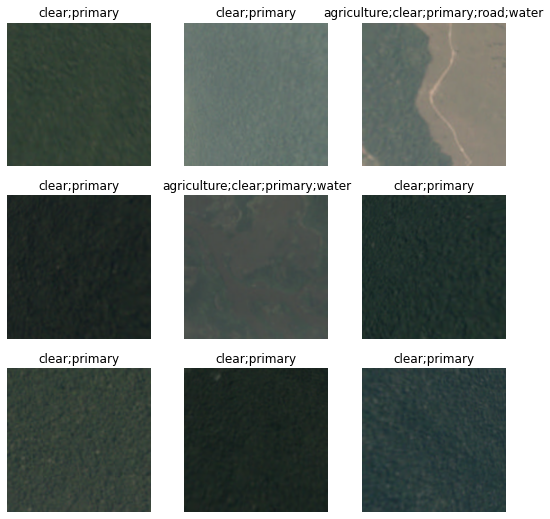

In [9]:
dls = ImageDataLoaders.from_df(df, path, fn_col=2, folder='train', label_delim=' ',
                               item_tfms=Resize(460), batch_tfms=aug_transforms(size=224))
dls.show_batch()

So a few things to note which the Fastai high level api has done:

- It's used our dataframe to load the data
- It uses the *path* variable to know which file path the images are located
- The 'fn_col' parameter tells it which column to use for the filenames, in this case column 2 is the new column we created for the complete filename
- The *folder* parameter tells it where the images are located under *path*
- The *label_delim* parameter tells it how to split the labels, in this case separated by spaces
- *item_tfms* a list of one or several transforms applied to the items before batching them for model training
- *batch_tfms* a list of one or several transforms applied to batches of images once they are formed during model training

So we can see we have a good level of configurability even at the high level api.

[There are many other high level api functions for Fastai vision applications for loading different types of data](https://docs.fast.ai/vision.data.html).

It will also be helpful to set up some metrics to measure our progress during training, specific to being a multi labelled classification task, and having an unbalanced dataset. A Good metric for this situation would be an F1 score for multiple classes, so lets set up some metrics for this now.

In [10]:
f1_macro = F1ScoreMulti(thresh=0.5, average='macro')
f1_macro.name = 'F1(macro)'
f1_samples = F1ScoreMulti(thresh=0.5, average='samples')
f1_samples.name = 'F1(samples)'

So we are almost ready to create our model and start training.

One consideration we have when creating a model is which model to use? as of date of this article, there are many pre-trained deep learning vision models, and many new ones being added. Which should we use?

Jeremy Howard, one of the co-founders of FastAI completed [a project where he looked at a number recent of vision models and evaluated and ranked them by different criteria](https://www.kaggle.com/code/jhoward/the-best-vision-models-for-fine-tuning).

These were based on Ros Wightmanns list of Pytorch state of the art image models library [timm](https://timm.fast.ai/).

Looking at these models and considering this use case: i'd like the best performing model but the best *smallest* model as we are not focussing here on getting the best results, rather to just demonstrate the usage of the Fastai library.

So looking with this criteria, i've selected the 'convnext_small_in22k' pre-trained image model to use.

Let's now create the model using the high-level api function *vision_learner*.

In [11]:
learn = vision_learner(dls, 'convnext_small_in22k', metrics=[partial(accuracy_multi, thresh=0.5), f1_macro, f1_samples])

So we have created our model, using our data, and added the metrics to use.

But what about the model learning rate? for this we can use another great Fastai api function *lr_find()*.

For more information on this concept and the research behind it, including discriminative learning rates this is a [great article](https://towardsdatascience.com/why-i-use-fastai-and-you-should-too-a421f6c99508).

SuggestedLRs(valley=0.0008317637839354575)

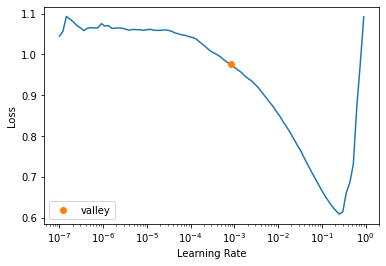

In [12]:
learn.lr_find()

So this gives us a good idea of the a good learning rate to use, lets set this and train the model for 2 epochs.

In [13]:
learn.fine_tune(2, 3e-2)

epoch,train_loss,valid_loss,accuracy_multi,F1(macro),F1(samples),time
0,1.044040,2.020892,0.497143,0.312559,0.430190,00:02


epoch,train_loss,valid_loss,accuracy_multi,F1(macro),F1(samples),time
0,0.955900,1.813314,0.411429,0.347462,0.411784,00:04
1,0.914945,1.890064,0.554286,0.363607,0.453518,00:04


We can see our model is slowly starting to improve.

Let's see how our model is predicting labels for our satellite images.

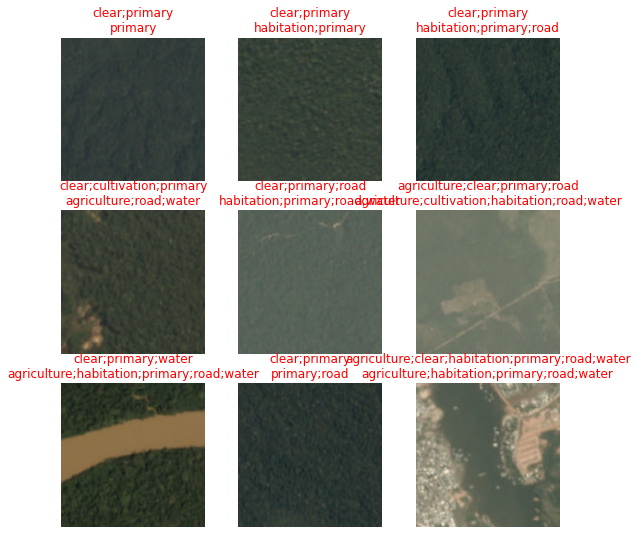

In [14]:
learn.show_results()

We can also get an idea of which images the model finds hardest to predict by using the *plot_top_losses()* function.

,target,predicted,probabilities,loss
0,clear;habitation;primary;road;water,agriculture;cultivation;habitation;road;water,"TensorBase([1.0000e+00, 5.3429e-10, 9.1896e-01, 5.3812e-01, 1.8748e-02,\n 9.9999e-01, 9.9779e-01])",5.9950785636901855
1,agriculture;clear;habitation;primary;road,agriculture;cultivation;habitation;primary;road;water,"TensorBase([1.0000e+00, 1.3865e-08, 9.7993e-01, 9.4586e-01, 5.2794e-01,\n 9.9999e-01, 9.9923e-01])",4.266438961029053
2,clear;primary;water,agriculture;habitation;primary;road;water,"TensorBase([9.9979e-01, 5.7836e-05, 1.7540e-01, 7.1101e-01, 5.7885e-01,\n 9.9740e-01, 9.9980e-01])",3.7381298542022705
3,clear;cultivation;primary,agriculture;road;water,"TensorBase([9.9726e-01, 3.5533e-04, 2.8459e-01, 3.0627e-01, 3.5213e-01,\n 9.9678e-01, 9.3701e-01])",3.573106050491333
4,agriculture;clear;habitation;primary;road;water,agriculture;habitation;primary;road;water,"TensorBase([9.9999e-01, 6.4912e-11, 1.6498e-01, 8.6925e-01, 8.6978e-01,\n 1.0000e+00, 9.9922e-01])",3.4169580936431885
5,agriculture;clear;primary;road,agriculture;cultivation;habitation;road;water,"TensorBase([9.9999e-01, 3.5587e-06, 6.8011e-01, 5.0741e-01, 3.6172e-02,\n 9.9992e-01, 9.7514e-01])",3.058271884918213
6,clear;primary;water,agriculture;habitation;primary;road;water,"TensorBase([9.9094e-01, 1.3812e-04, 4.5300e-01, 6.2815e-01, 6.4152e-01,\n 7.7717e-01, 8.5307e-01])",2.4697818756103516
7,clear;primary,agriculture;habitation;primary;road;water,"TensorBase([0.9377, 0.0013, 0.1471, 0.7862, 0.9317, 0.9659, 0.6219])",2.221360206604004
8,clear;primary,agriculture;road,"TensorBase([6.0217e-01, 3.6376e-04, 3.3483e-02, 3.6663e-01, 4.4091e-01,\n 5.4576e-01, 9.7288e-02])",1.5774089097976685


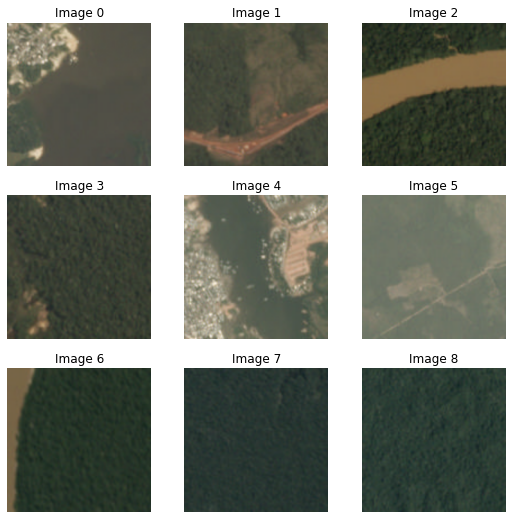

In [15]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9)

### Using the Mid Level API - Version 1

Using the mid-level api can give us more control over how the dataset is constructed, which will be determined by the task.

The [Fastai data block tutorial](https://docs.fast.ai/tutorial.datablock.html) is a great way to understand the methodology behind what the mid level api can do.

So there are many ways we could construct the data using the mid level api, however JH encourages us to consider a list of questions that can be helpful for choosing the best method which are:

- what are the types of our inputs and targets? Images and multiple labels.
- where is the data? In a dataframe.
- how do we know if a sample is in the training or the validation set? A column of our dataframe.
- how do we get an image? By looking at the column 'filename'.
- how do we know the label of an image? By looking at the column 'tags'.
- do we want to apply a function to a given sample? Yes, we need to resize everything to a given size.
- do we want to apply a function to a batch after it’s created? Yes, we want data augmentation.

So while our model input (x -images) and outputs (y - labels) are in the dataframe, we need to do need to do a little processing on these dataframe columns before being able to use them, for example the filenames need filepaths added, and the labels need splitting. 

We can create a datablock this way to address these needs.

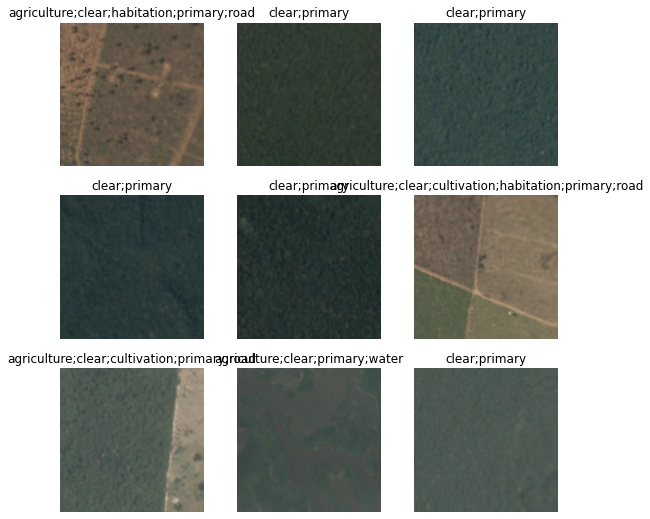

In [16]:
planet = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader('filename', pref=str(path/'train') + os.path.sep),
                   get_y=ColReader('tags', label_delim=' '),
                   item_tfms = Resize(460),
                   batch_tfms=aug_transforms(size=224))
dls = planet.dataloaders(df)
dls.show_batch()

We can see we used the *get_x & get_y* parameters to process the images and labels columns using the *ColReader()* function. We can also see how the answers to those questions directly translates to different parameters in the DataBlock function.

### Using the Mid Level API - Version 2

Another way we could approach this, for getting our images and labels correctly processed is by defining our own functions for doing this using a *lambda function*.

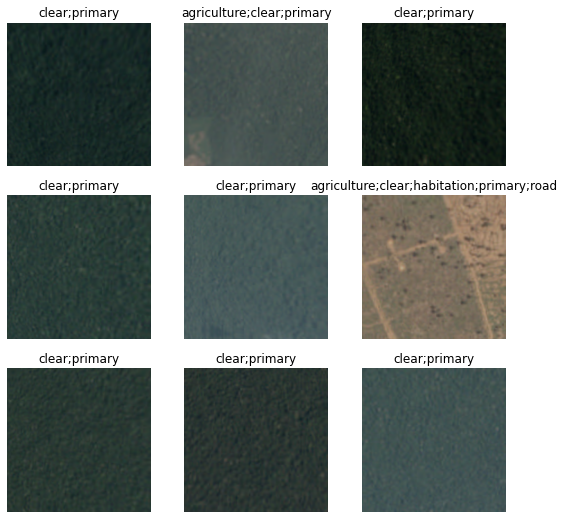

In [17]:
planet = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=lambda x:path/"train"/f'{x[2]}',
                   get_y=lambda x:x[1].split(' '),
                   item_tfms = Resize(460),
                   batch_tfms=aug_transforms(size=224))
dls = planet.dataloaders(df)
dls.show_batch()

### Using the Mid Level API - Version 3

Alternatively, for our lambda functions we could use the column names rather than the indexes.

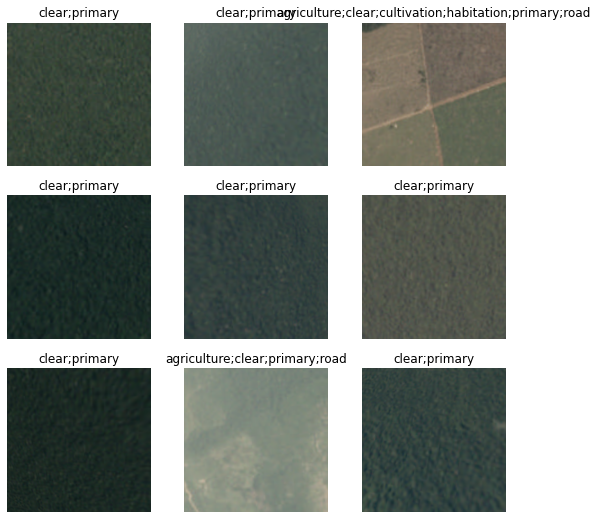

In [18]:
planet = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=lambda o:f'{path}/train/'+o.filename,
                   get_y=lambda o:o.tags.split(),
                   item_tfms = Resize(460),
                   batch_tfms=aug_transforms(size=224))
dls = planet.dataloaders(df)
dls.show_batch()

### Using the Mid Level API - Version 4

Both of these previous methods would involve iterating over all the rows of the dataframe. For large datasets & dataframes, this could prove very costly in terms of time - not the ideal way for Fastai !

A better and faster way would be to use the *from_columns()* Datablock method. This uses a user-defined function passed in the *get_items* parameter to convert the columns into numpy arrays and work with these which would be quicker.

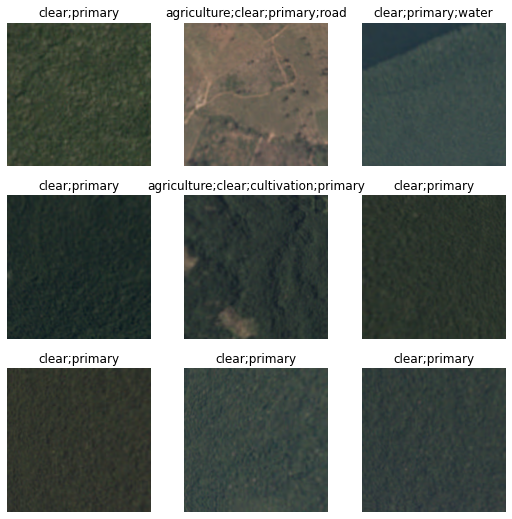

In [19]:
def _amazon_items(x): return (
    f'{path}/train/'+x.filename, x.tags.str.split())

planet = DataBlock.from_columns(blocks=(ImageBlock, MultiCategoryBlock),
                   get_items=_amazon_items,
                   item_tfms = Resize(460),
                   batch_tfms=aug_transforms(size=224))
dls = planet.dataloaders(df)
dls.show_batch()

### Training our Model More

Let's now train our model for a few more epochs and observe the progress.

In [20]:
learn.fine_tune(12, 1e-2)

epoch,train_loss,valid_loss,accuracy_multi,F1(macro),F1(samples),time
0,0.839966,1.319353,0.628571,0.423056,0.526470,00:02


epoch,train_loss,valid_loss,accuracy_multi,F1(macro),F1(samples),time
0,0.816123,0.863024,0.662857,0.434543,0.519232,00:04
1,0.743988,0.717785,0.714286,0.561080,0.625896,00:04
2,0.748999,0.740482,0.645714,0.488145,0.593423,00:04
3,0.726016,0.943211,0.605714,0.451780,0.529645,00:04
4,0.710094,1.014733,0.622857,0.514764,0.472312,00:04
5,0.707066,0.860917,0.697143,0.643097,0.563126,00:04
6,0.692620,0.711039,0.702857,0.556803,0.558268,00:04
7,0.679113,0.690488,0.691429,0.542517,0.570459,00:04
8,0.668592,0.613841,0.720000,0.580288,0.608078,00:04
9,0.664969,0.561042,0.748571,0.617624,0.648078,00:04


## Conclusion

In this article we used the Amazon images dataset to illustrate the different ways we can use the Fastai library to prepare the data for the task. We used both the high & mid level api, and in particular explored the many options the mid level api offers to make it easy and fast to prepare data for deep learning model training.